In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('CreditCardFraudEDA').getOrCreate()
raw_data = spark.read.csv('fraudTrain.csv', header=True, inferSchema=True)

In [ ]:
raw_data.printSchema()
raw_data.show(5)

root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)

+---+---------------------+----------------+--------------------+-------------+------+---------+-------+--

In [ ]:
num_rows = raw_data.count()
num_columns = len(raw_data.columns)

print(num_rows)
print(num_columns)

1296675
23


In [ ]:
last_rows = raw_data.tail(5)
for row in last_rows:
    print(row)

Row(_c0=1296670, trans_date_trans_time=datetime.datetime(2020, 6, 21, 12, 12, 8), cc_num=30263540414123, merchant='fraud_Reichel Inc', category='entertainment', amt=15.56, first='Erik', last='Patterson', gender='M', street='162 Jessica Row Apt. 072', city='Hatch', state='UT', zip=84735, lat=37.7175, long=-112.4777, city_pop=258, job='Geoscientist', dob=datetime.date(1961, 11, 24), trans_num='440b587732da4dc1a6395aba5fb41669', unix_time=1371816728, merch_lat=36.841266, merch_long=-111.69076499999998, is_fraud=0)
Row(_c0=1296671, trans_date_trans_time=datetime.datetime(2020, 6, 21, 12, 12, 19), cc_num=6011149206456997, merchant='fraud_Abernathy and Sons', category='food_dining', amt=51.7, first='Jeffrey', last='White', gender='M', street='8617 Holmes Terrace Suite 651', city='Tuscarora', state='MD', zip=21790, lat=39.2667, long=-77.5101, city_pop=100, job='Production assistant, television', dob=datetime.date(1979, 12, 11), trans_num='278000d2e0d2277d1de2f890067dcc0a', unix_time=137181673

In [ ]:
raw_data.describe().show()

+-------+-----------------+--------------------+-------------------+-------------+------------------+-------+-------+-------+--------------------+-------+-------+------------------+------------------+------------------+-----------------+------------------+--------------------+--------------------+-----------------+------------------+--------------------+
|summary|              _c0|              cc_num|           merchant|     category|               amt|  first|   last| gender|              street|   city|  state|               zip|               lat|              long|         city_pop|               job|           trans_num|           unix_time|        merch_lat|        merch_long|            is_fraud|
+-------+-----------------+--------------------+-------------------+-------------+------------------+-------+-------+-------+--------------------+-------+-------+------------------+------------------+------------------+-----------------+------------------+--------------------+---------

In [ ]:
from pyspark.sql.functions import count, when, col

raw_data.select([count(when(col(c).isNull(), c)).alias(c) for c in raw_data.columns]).show()

+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|_c0|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|unix_time|merch_lat|merch_long|is_fraud|
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|  0|                    0|     0|       0|       0|  0|    0|   0|     0|     0|   0|    0|  0|  0|   0|       0|  0|  0|        0|        0|        0|         0|       0|
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+



In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

numeric_columns = ['cc_num', 'amt', 'zip','long','city_pop','unix_time','merch_lat','merch_long','is_fraud']

assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
raw_data_vectorized = assembler.transform(raw_data)

correlation_matrix = Correlation.corr(raw_data_vectorized, 'features').head()
print(correlation_matrix[0])


DenseMatrix([[ 1.00000000e+00,  1.76939977e-03,  4.14589540e-02,
              -4.82778009e-02, -8.99106682e-03,  3.53664067e-04,
              -5.89421349e-02, -4.82519959e-02, -9.81455613e-04],
             [ 1.76939977e-03,  1.00000000e+00,  1.84340203e-03,
              -1.87475599e-04,  5.81828398e-03, -2.92997831e-04,
              -1.87254740e-03, -1.50995346e-04,  2.19403889e-01],
             [ 4.14589540e-02,  1.84340203e-03,  1.00000000e+00,
              -9.09732122e-01,  7.84670560e-02,  6.70469820e-04,
              -1.13561358e-01, -9.08924027e-01, -2.16190728e-03],
             [-4.82778009e-02, -1.87475599e-04, -9.09732122e-01,
               1.00000000e+00, -5.27146379e-02, -6.41788388e-04,
              -1.54518140e-02,  9.99119582e-01,  1.72081275e-03],
             [-8.99106682e-03,  5.81828398e-03,  7.84670560e-02,
              -5.27146379e-02,  1.00000000e+00, -1.71400250e-03,
              -1.54781442e-01, -5.26867904e-02,  2.13590242e-03],
             [ 3.536

In [ ]:
# raw_data.groupBy('category').count().show()
# raw_data.groupBy('is_fraud').count().show()

# raw_data.printSchema()
# raw_data.describe().show()
raw_data.select("is_fraud").groupBy("is_fraud").count().show()


+--------+-------+
|is_fraud|  count|
+--------+-------+
|       1|   7506|
|       0|1289169|
+--------+-------+



In [ ]:
# Convert to Pandas raw_dataFrame
pandas_df = raw_data.toPandas()

pandas_df.head()

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
# Fraud vs Non-Fraud Transactions (Count Plot)
sns.set_style('whitegrid')

plt.figure(figsize=(6,4))
sns.countplot(raw_data=pandas_df, x='is_fraud', palette='viridis')
plt.title('Fraud vs Non-Fraud Transactions')
plt.xlabel('Is Fraud?')
plt.ylabel('Number of Transactions')
plt.show()

In [ ]:
# Distribution of Transaction Amounts (amt)

plt.figure(figsize=(8,5))
sns.histplot(pandas_df['amt'], bins=100, kde=True, color='coral')
plt.xlim(0, 500)
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Count')
plt.show()

In [ ]:
# Boxplot: Amounts for Fraud vs Non-Fraud

plt.figure(figsize=(8,5))
sns.boxplot(raw_data=pandas_df, x='is_fraud', y='amt', palette='coolwarm')
plt.ylim(0, 500)
plt.title('Transaction Amount by Fraud Status')
plt.xlabel('Is Fraud?')
plt.ylabel('Transaction Amount ($)')
plt.show()

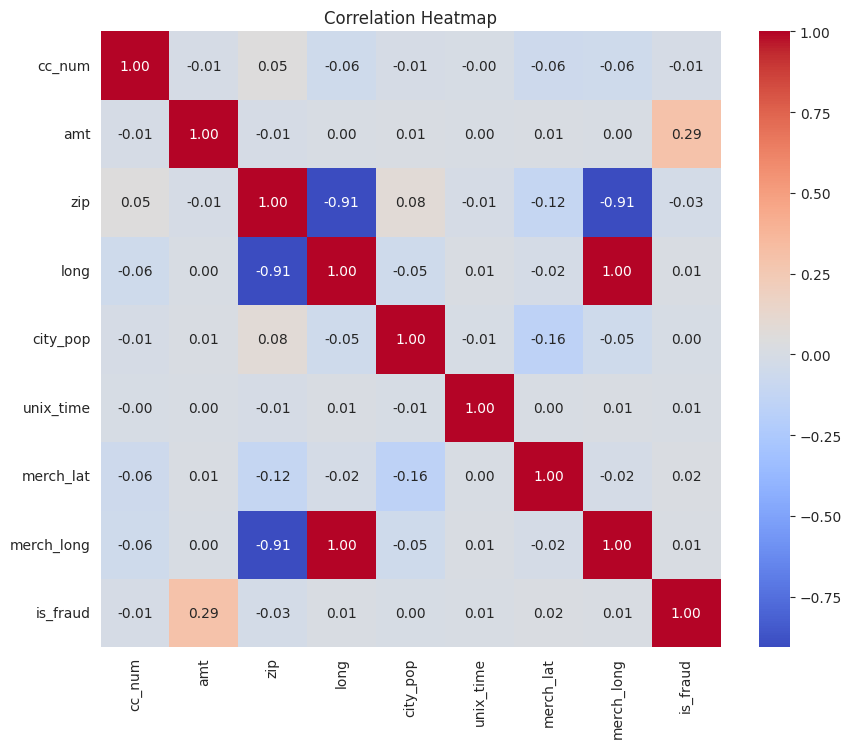

In [ ]:
# Correlation Heatmap  => on numeric columns
numeric_columns = ['cc_num', 'amt', 'zip','long','city_pop','unix_time','merch_lat','merch_long','is_fraud']

corr = pandas_df[numeric_columns].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
# Category Distribution (Top 10 Categories)

top_categories = pandas_df['category'].value_counts().nlargest(10)

print(top_categories)

plt.figure(figsize=(10,6))
sns.barplot(x=top_categories.values, y=top_categories.index, palette='magma')
plt.title('Top 10 Merchant Categories by Transaction Count')
plt.xlabel('Number of Transactions')
plt.ylabel('Merchant Category')
plt.show()

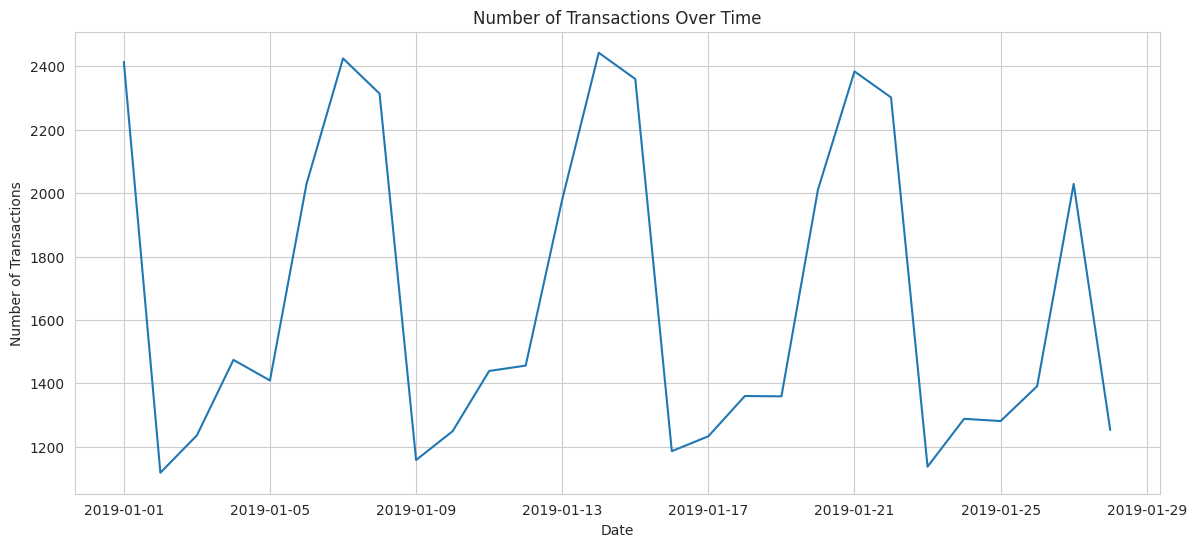

In [ ]:
# Time Series: Number of Transactions Over Time

pandas_df['trans_date_trans_time'] = pd.to_datetime(pandas_df['trans_date_trans_time'])

daily_transactions = pandas_df.groupby(pandas_df['trans_date_trans_time'].dt.date).size()

plt.figure(figsize=(14,6))
daily_transactions.plot()
plt.title('Number of Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()


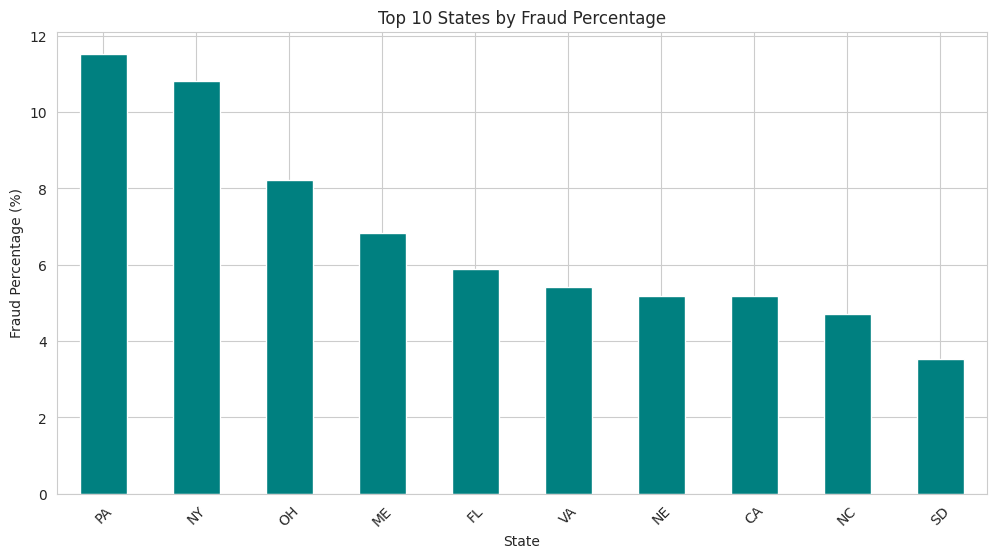

In [ ]:
#  Fraud Rate by State

fraud_by_state = pandas_df[pandas_df['is_fraud'] == 1]['state'].value_counts(normalize=True) * 100

plt.figure(figsize=(12,6))
fraud_by_state[:10].plot(kind='bar', color='teal')
plt.title('Top 10 States by Fraud Percentage')
plt.ylabel('Fraud Percentage (%)')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

In [ ]:
# Only keeping relevant columns
data = raw_data.select(
    'trans_date_trans_time', 'category', 'amt',
    'lat', 'long', 'merch_lat', 'merch_long', 'is_fraud'
)

NameError: name 'raw_data' is not defined

In [ ]:
from pyspark.sql.functions import hour, dayofmonth

data = data.withColumn('hour', hour('trans_date_trans_time'))
data = data.withColumn('day', dayofmonth('trans_date_trans_time'))

In [ ]:
# String Indexing for category
indexer = StringIndexer(inputCol="category", outputCol="category_indexed")

# Assembling features
feature_cols = ['amt', 'lat', 'long', 'merch_lat', 'merch_long', 'hour', 'day', 'category_indexed']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

Decision Tree Classifier

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

dt = DecisionTreeClassifier(labelCol="is_fraud", featuresCol="features")

pipeline_dt = Pipeline(stages=[indexer, assembler, dt])

train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
model_dt = pipeline_dt.fit(train_data)
predictions_dt = model_dt.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="accuracy")
accuracy_dt = evaluator.evaluate(predictions_dt)

print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")
